## Udacity Machine Learning Engineer Nanodegree
### Capstone Project: 
### Predicting the Daily Direction of the S&P500

#### Completed and Submitted by Pavel Liashkov
#### August 2019


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import warnings

from time import time, monotonic
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from IPython.display import display

warnings.filterwarnings('ignore')

# Read data from SP500_historical.csv - data contains returns for the S&P500 and VIX index
# Source: Yahoo Finance

df = pd.read_csv("SP500_2019_historical.csv",header=0)
print("Market data read successfully!")
print(f"Number of data points: {len(df)}")

np.random.seed(8)

Market data read successfully!
Number of data points: 6547


In [2]:
df.head()

,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,Vix_Open,Vix_High,Vix_Low,Vix_Close
0,2019-08-14,2894.149902,2894.149902,2839.639893,2840.600098,4312530000,17.809999,22.709999,17.750000,22.100000
1,2019-08-13,2880.719971,2943.310059,2877.050049,2926.320068,3853600000,21.280001,21.639999,17.520000,17.520000
2,2019-08-12,2907.070068,2907.580078,2873.139893,2882.699951,2851630000,17.870001,21.260000,17.770000,21.090000
3,2019-08-09,2930.510010,2935.750000,2900.149902,2918.649902,3350640000,18.139999,19.440001,17.309999,17.969999
4,2019-08-08,2896.209961,2938.719971,2894.469971,2938.090088,4106370000,19.360001,19.889999,16.820000,16.910000


In [3]:
df.describe()

,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,Vix_Open,Vix_High,Vix_Low,Vix_Close
count,6547.000000,6547.000000,6547.000000,6547.000000,6.547000e+03,6547.000000,6547.000000,6547.000000,6547.000000
mean,1363.529833,1371.460411,1355.043503,1363.815399,2.446404e+09,19.464616,20.258428,18.713573,19.380962
std,598.287574,600.048837,596.254592,598.273137,1.707425e+09,8.116787,8.523738,7.654372,8.049575
min,439.140015,444.720001,435.859985,438.920013,1.499000e+07,9.010000,9.310000,8.560000,9.140000
25%,996.759979,1006.165008,987.854981,997.279999,9.072500e+08,13.525000,14.140000,13.040000,13.480000
50%,1256.560059,1264.739990,1246.880005,1256.880005,2.365770e+09,17.590000,18.240000,16.820000,17.500000
75%,1544.049988,1549.109985,1536.315002,1543.549988,3.659415e+09,23.005000,23.855001,22.185001,22.870001
max,3024.469971,3027.979980,3014.300049,3025.860107,1.145623e+10,80.739998,89.529999,72.760002,80.860001


In [4]:
# Print the column headers
df.dtypes.index

Index(['Date', 'SP_Open', 'SP_High', 'SP_Low', 'SP_Close', 'SP_Volume',
       'Vix_Open', 'Vix_High', 'Vix_Low', 'Vix_Close'],
      dtype='object')

In [5]:
# Convert the 'Date' column data from a string into a form that can be manipulated mathematically
# Calculate the 'Days_Since_Open' feature, which is a measure of how many days have passed since the market last opened

from datetime import datetime

df["Date"] = pd.to_datetime(df["Date"])

df["Days_Since_Open"] = (df["Date"] - df["Date"].shift(-1))
df["Days_Since_Open"] = df["Days_Since_Open"].astype("timedelta64[D]")

Text(0.5, 0, 'Trading Days Since Most Recent Day')

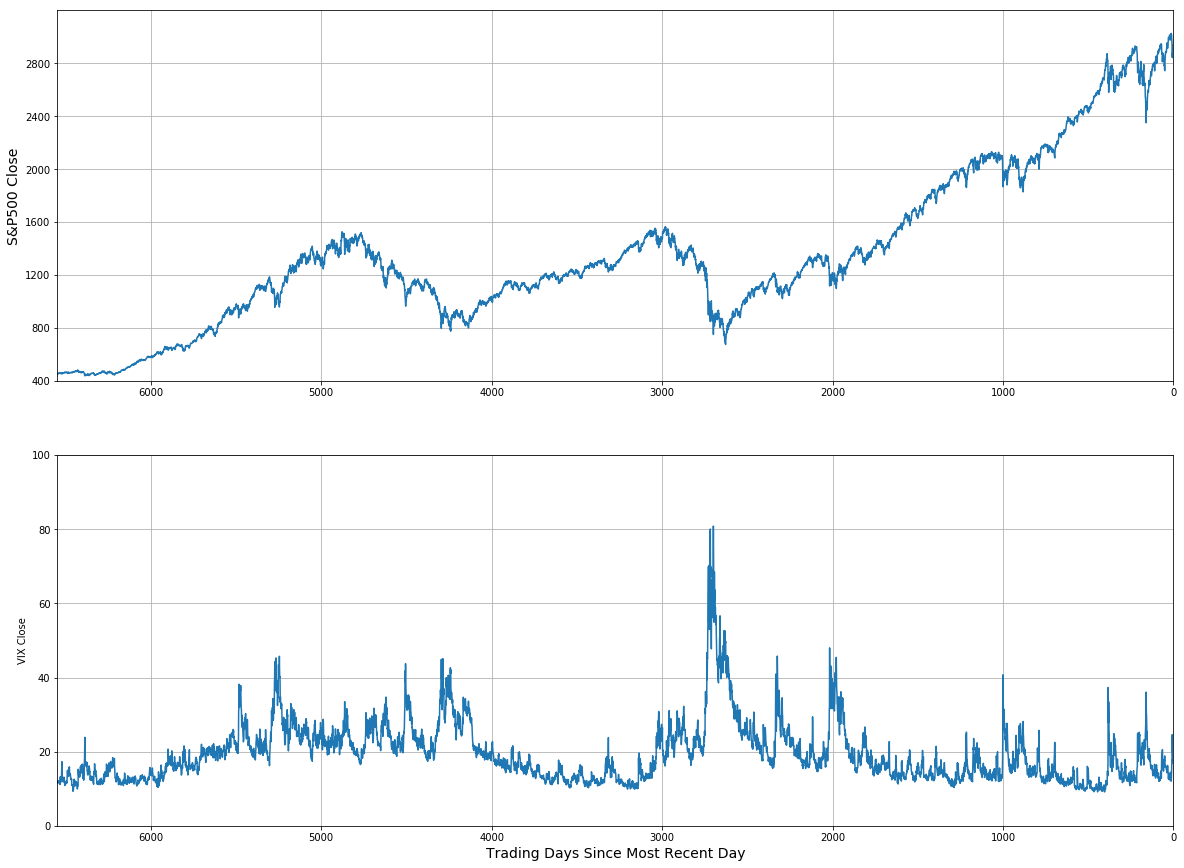

In [6]:
# Visualize
%matplotlib inline

import matplotlib.pyplot as plt

plot_data = df.SP_Close
plot_data_VIX = df.Vix_Close

fig, axes = plt.subplots(2, 1)
fig.set_size_inches(20, 15, forward=True)

axes[0].axis([6547,0,400,3200])
axes[0].plot(plot_data)
axes[0].set_ylabel("S&P500 Close", fontsize=14)
axes[0].set_yticks([400,800,1200,1600,2000,2400,2800])
axes[0].grid(True)

axes[1].axis([6547,0,0,100])
axes[1].plot(plot_data_VIX)
axes[1].set_ylabel("VIX Close")
axes[1].grid(True)
plt.xlabel("Trading Days Since Most Recent Day", fontsize=14)

Text(0.5, 0, 'Trading Days Since Most Recent Day')

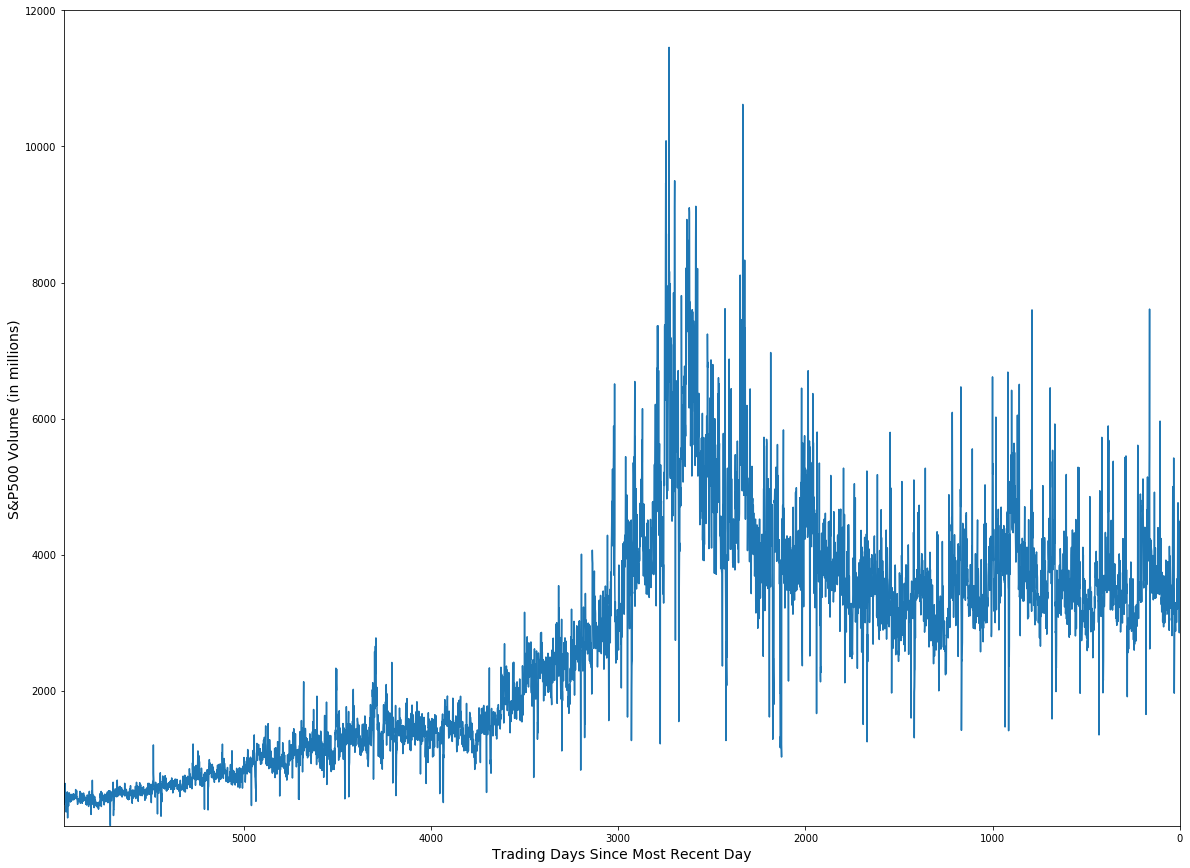

In [7]:
plot_data_Volume = df.SP_Volume / 1000000

fig = plt.figure()
fig.set_size_inches(20, 15, forward=True)
plt.axis([5962,0,14,12000])
plt.plot(plot_data_Volume)
plt.ylabel("S&P500 Volume (in millions)", fontsize=14)
plt.xlabel("Trading Days Since Most Recent Day", fontsize=14)

In [8]:
# Calculate the "Break_Coming" feature, which is a measure of whether the market will close for a break on the next day

df["Break_Coming"] = df["Days_Since_Open"].shift(1)

df.loc[df["Break_Coming"]<=1,"Break_Coming"] = 0
df.loc[df["Break_Coming"]>1,"Break_Coming"] = 1

df.Break_Coming.fillna(0, inplace=True)

In [9]:
# Calculate the 'Overnight_Return' feature

df["Overnight_Return"] = df["SP_Open"] / df["SP_Close"].shift(-1) - 1

In [10]:
# Calculate the 'No_Overnight_Change' value. This is not a feature, but was used to identify unreliable data rows
# See accompanying report for further details

df["No_Overnight_Change"] = df["Overnight_Return"]

df.loc[df["No_Overnight_Change"] == 0.00, "No_Overnight_Change"] = 1
df.loc[df["No_Overnight_Change"] != 1, "No_Overnight_Change"] = 0

In [11]:
# Calculate the 'Overnight_VIX' feature, which measures whether the VIX has opened up or down relative to previous day

df["Overnight_VIX"] = df["Vix_Open"] / df["Vix_Close"].shift(-1) - 1

In [12]:
# Calculate the 'O_to_O' feature, which compares the current opening price to the previous day

df["O_to_O"] = df["SP_Open"] / df["SP_Open"].shift(-1) - 1

In [13]:
# Calculate 11 different trailing return features, 9 based on the S&P500 data and 2 based on VIX data

df["Trail_1d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-2) - 1
df["Trail_2d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-3) - 1
df["Trail_3d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-4) - 1
df["Trail_4d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-5) - 1
df["Trail_5d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-6) - 1
df["Trail_21d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-22) - 1
df["Trail_63d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-64) - 1
df["Trail_126d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-127) - 1
df["Trail_252d_Ret"] = df["SP_Close"].shift(-1) / df["SP_Close"].shift(-253) - 1

df["Trail_1d_VIX"] = df["Vix_Close"].shift(-1) / df["Vix_Close"].shift(-2) - 1
df["Trail_5d_VIX"] = df["Vix_Close"].shift(-1) / df["Vix_Close"].shift(-6) - 1

In [14]:
# Calculate 2 different trailing volume features, which measure whether the last day's volume is above or below
# recent averages

df["Trail_1d_Rel_Vol"] = (
    df["SP_Volume"].shift(-1) / (df["SP_Volume"].rolling(window=4).mean().shift(-5)) - 1
)

df["Trail_5d_Rel_Vol"] = (
    df["SP_Volume"].rolling(window=5).mean().shift(-5)
    / (df["SP_Volume"].rolling(window=21).mean().shift(-26))
    - 1
)

In [15]:
# Calculate the 'Trail_1d_PtT' feature, which measure how much the S&P500 moved from high to low values on the
# previous trading day

df["Trail_1d_PtT"] = (df["SP_High"].shift(-1) - df["SP_Low"].shift(-1)) / (
    0.5 * (df["SP_Open"].shift(-1) + df["SP_Close"].shift(-1))
)

In [16]:
# Calculate the 'Trail_1d_VIX_PtT' feature, which measure how much the VIX moved from high to low values on the
# previous trading day

df["Trail_1d_VIX_PtT"] = (df["Vix_High"].shift(-1) - df["Vix_Low"].shift(-1)) / (
    0.5 * (df["Vix_Open"].shift(-1) + df["Vix_Close"].shift(-1))
)

In [17]:
# Calculate the 'Intraday_Increase' label, which is ultimately what the machine learner should predict, and as is a
# measure of whether the S&P500 increased on a given day (value = 1) or not (value = 0)

df["Intraday_Increase"] = df["SP_Close"] - df["SP_Open"]

df.loc[df["Intraday_Increase"] > 0, "Intraday_Increase"] = 1
df.loc[df["Intraday_Increase"] <= 0, "Intraday_Increase"] = 0

I am now going to delete those rows that have N/A values (e.g. you cannot do a 252 day trailing return if there are fewer than 252 days trailing a given data point)

In [18]:
clean_df = df.dropna()

print(f"Number of clean data points: {len(clean_df)}")
print(f"Number of full data points: {len(df)}")

Number of clean data points: 6294
Number of full data points: 6547


I will also delete rows where 'No_Overnight_Change' is equal to 1. These are points where the opening value is IDENTICAL to the previous closing data, which likely reflects missing true opening prices (the chances of the market opening at the identical level as the previous close are slim to none). Most of these points came from the older portion of the data set. There were almost no points like this in the most recent 10 years:

In [19]:
validated_data = clean_df[clean_df.No_Overnight_Change != 1]
print(f"Number of data points: {len(validated_data)}")

Number of data points: 3330


Next, I need to drop columns that would allow the machine learning algorithm to 'know the future'. For example, it cannot be trained using SP_Close for any given day, since that would trivially allow it to calculate whether the market closed up on any given day. It can only be provided information that one would know at the start of the day (i.e. data from previous days and the opening data). This rules out High, Low and Close values for the market and the VIX and also the market volume for any given day. Finally, I will limit the analysis to relative returns, not absolute values of the indeces, given that the stock market tends to increase with time and hence comparing the absolute value of the S&P500 over a 20+ year period will not be helpful. 

In summary, the final data set will consist of only the 20 calculated features and the 1 label, for the 2,678 validated data rows.

In [20]:
# Print the column headers of the current data set
print(validated_data.dtypes.index)

Index(['Date', 'SP_Open', 'SP_High', 'SP_Low', 'SP_Close', 'SP_Volume',
       'Vix_Open', 'Vix_High', 'Vix_Low', 'Vix_Close', 'Days_Since_Open',
       'Break_Coming', 'Overnight_Return', 'No_Overnight_Change',
       'Overnight_VIX', 'O_to_O', 'Trail_1d_Ret', 'Trail_2d_Ret',
       'Trail_3d_Ret', 'Trail_4d_Ret', 'Trail_5d_Ret', 'Trail_21d_Ret',
       'Trail_63d_Ret', 'Trail_126d_Ret', 'Trail_252d_Ret', 'Trail_1d_VIX',
       'Trail_5d_VIX', 'Trail_1d_Rel_Vol', 'Trail_5d_Rel_Vol', 'Trail_1d_PtT',
       'Trail_1d_VIX_PtT', 'Intraday_Increase'],
      dtype='object')


In [21]:
# Drop the columns that are not one of the 20 features or the label
data = validated_data.drop(validated_data.columns[[0,1,2,3,4,5,6,7,8,9,13]], axis=1)

In [22]:
# Print the headers of 'data', to validate that the correct columns were dropped
print(data.dtypes.index)

Index(['Days_Since_Open', 'Break_Coming', 'Overnight_Return', 'Overnight_VIX',
       'O_to_O', 'Trail_1d_Ret', 'Trail_2d_Ret', 'Trail_3d_Ret',
       'Trail_4d_Ret', 'Trail_5d_Ret', 'Trail_21d_Ret', 'Trail_63d_Ret',
       'Trail_126d_Ret', 'Trail_252d_Ret', 'Trail_1d_VIX', 'Trail_5d_VIX',
       'Trail_1d_Rel_Vol', 'Trail_5d_Rel_Vol', 'Trail_1d_PtT',
       'Trail_1d_VIX_PtT', 'Intraday_Increase'],
      dtype='object')


In [23]:
# Optional: export the final data set that will be used for training / testing the algorithms
np.savetxt("./data/eval-data.csv", data, delimiter=",")

In [24]:
# Output basic statistics on the dataset
data.describe()

,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O_to_O,Trail_1d_Ret,Trail_2d_Ret,Trail_3d_Ret,Trail_4d_Ret,Trail_5d_Ret,...,Trail_63d_Ret,Trail_126d_Ret,Trail_252d_Ret,Trail_1d_VIX,Trail_5d_VIX,Trail_1d_Rel_Vol,Trail_5d_Rel_Vol,Trail_1d_PtT,Trail_1d_VIX_PtT,Intraday_Increase
count,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,...,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000
mean,1.447147,0.213213,0.000047,0.006234,0.000299,0.000310,0.000589,0.000782,0.001079,0.001375,...,0.017100,0.036296,0.072743,0.003246,0.012588,0.008577,0.009784,0.012549,0.091038,0.546246
std,0.875760,0.409639,0.002176,0.042953,0.011524,0.012179,0.016308,0.019199,0.021851,0.024141,...,0.076495,0.114764,0.160846,0.078729,0.163340,0.177566,0.151638,0.010642,0.057333,0.497931
min,1.000000,0.000000,-0.014302,-0.300366,-0.087119,-0.090350,-0.124174,-0.139059,-0.172221,-0.183401,...,-0.417706,-0.464658,-0.488228,-0.295727,-0.428273,-0.758845,-0.669690,0.001457,0.014966,0.000000
25%,1.000000,0.000000,-0.000564,-0.014992,-0.003890,-0.003986,-0.006084,-0.007131,-0.008519,-0.008703,...,-0.014485,-0.011455,0.012606,-0.040292,-0.079975,-0.088769,-0.082820,0.006137,0.055498,0.000000
50%,1.000000,0.000000,-0.000007,0.001216,0.000715,0.000600,0.001387,0.002177,0.002755,0.003211,...,0.029995,0.051558,0.106995,-0.004986,-0.009050,-0.006230,0.000189,0.009645,0.077256,1.000000
75%,1.000000,0.000000,0.000815,0.023975,0.005045,0.005376,0.008413,0.010254,0.012334,0.013821,...,0.061205,0.095778,0.166477,0.035335,0.076371,0.085612,0.087572,0.015210,0.107727,1.000000
max,5.000000,1.000000,0.015456,0.510725,0.106712,0.115800,0.132064,0.139480,0.179735,0.191112,...,0.388172,0.502372,0.685734,1.155979,2.129032,2.045477,0.947982,0.107198,0.828529,1.000000


In [25]:
# Separate features and labels:

X = pd.DataFrame(data.loc[:, "Days_Since_Open":"Trail_1d_VIX_PtT"], dtype="float32")
y = pd.DataFrame(data.loc[:, "Intraday_Increase"], dtype="float32")

# Summarize the label data
y.describe()

,Intraday_Increase
count,3330.000000
mean,0.546246
std,0.497931
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# SKLearn Supervised Learning Algorithms:

The next few blocks of code will develop and optimize three SKLearn supervised learning classification algorithms, namely Decision Trees (DT), Naive Bayes, and Support Vector Machines (SVM). This code is based on code from project 2 (student intervention) of the Udacity Machine Learning Nanodegree.

In [26]:
# Split the data into train, validation and test sets:
# Shuffling will not be used because test data should be drawn from the latest data points, to remove any risk of
# the learning algorithms glimpsing the future

X_train = X[252:]
X_test = X[:252]

y_train = y[252:]
y_test = y[:252]

y_train = np.reshape(y_train.values,[3078,])
y_test = np.reshape(y_test.values,[252,])

describe_train = pd.DataFrame(X_train)
describe_test = pd.DataFrame(X_test)

describe_train_labels = pd.DataFrame(y_train)
describe_test_labels = pd.DataFrame(y_test)


display(describe_train.describe())
display(describe_test.describe())

display(describe_train_labels.describe())
display(describe_test_labels.describe())

,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O_to_O,Trail_1d_Ret,Trail_2d_Ret,Trail_3d_Ret,Trail_4d_Ret,Trail_5d_Ret,Trail_21d_Ret,Trail_63d_Ret,Trail_126d_Ret,Trail_252d_Ret,Trail_1d_VIX,Trail_5d_VIX,Trail_1d_Rel_Vol,Trail_5d_Rel_Vol,Trail_1d_PtT,Trail_1d_VIX_PtT
count,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000,3078.000000
mean,1.446719,0.212151,0.000046,0.006150,0.000313,0.000321,0.000615,0.000813,0.001121,0.001434,0.005732,0.017248,0.036780,0.074145,0.003135,0.011645,0.008692,0.009608,0.012684,0.089157
std,0.877028,0.408897,0.001859,0.043372,0.011703,0.012340,0.016476,0.019337,0.021982,0.024284,0.045173,0.077070,0.117462,0.166106,0.078115,0.161518,0.179118,0.153728,0.010836,0.056093
min,1.000000,0.000000,-0.014194,-0.300366,-0.087119,-0.090350,-0.124174,-0.139059,-0.172221,-0.183401,-0.280077,-0.417706,-0.464658,-0.488228,-0.295727,-0.428273,-0.758845,-0.669690,0.001457,0.014966
25%,1.000000,0.000000,-0.000474,-0.015116,-0.003890,-0.004000,-0.006076,-0.006999,-0.008500,-0.008522,-0.013589,-0.013863,-0.007938,0.010176,-0.039899,-0.079713,-0.089414,-0.083337,0.006168,0.054525
50%,1.000000,0.000000,-0.000007,0.000981,0.000716,0.000606,0.001311,0.002177,0.002703,0.003162,0.012425,0.030269,0.053175,0.114676,-0.004910,-0.008690,-0.006439,0.000189,0.009756,0.075715
75%,1.000000,0.000000,0.000740,0.023931,0.005045,0.005366,0.008413,0.010261,0.012329,0.013794,0.031303,0.061822,0.096742,0.171213,0.035231,0.074037,0.087463,0.090737,0.015306,0.106191
max,5.000000,1.000000,0.015046,0.510725,0.106712,0.115800,0.132064,0.139480,0.179735,0.191112,0.234342,0.388172,0.502372,0.685734,1.155979,2.129032,2.045477,0.947982,0.107198,0.828529


,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O_to_O,Trail_1d_Ret,Trail_2d_Ret,Trail_3d_Ret,Trail_4d_Ret,Trail_5d_Ret,Trail_21d_Ret,Trail_63d_Ret,Trail_126d_Ret,Trail_252d_Ret,Trail_1d_VIX,Trail_5d_VIX,Trail_1d_Rel_Vol,Trail_5d_Rel_Vol,Trail_1d_PtT,Trail_1d_VIX_PtT
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.452381,0.226190,0.000056,0.007257,0.000122,0.000178,0.000268,0.000405,0.000567,0.000659,0.004866,0.015291,0.030386,0.055626,0.004599,0.024107,0.007174,0.011927,0.010909,0.114004
std,0.861826,0.419196,0.004517,0.037512,0.009066,0.010033,0.014121,0.017453,0.020218,0.022353,0.043339,0.069199,0.074178,0.067614,0.086031,0.184121,0.157691,0.123530,0.007730,0.066730
min,1.000000,0.000000,-0.014302,-0.134107,-0.042740,-0.032864,-0.052761,-0.062171,-0.076609,-0.076530,-0.113138,-0.194655,-0.134693,-0.124217,-0.179748,-0.356252,-0.569309,-0.260001,0.002937,0.021484
25%,1.000000,0.000000,-0.002231,-0.014145,-0.003914,-0.003558,-0.006473,-0.008650,-0.010214,-0.010081,-0.025964,-0.026455,-0.028558,0.021518,-0.045626,-0.090277,-0.081264,-0.071740,0.005546,0.069491
50%,1.000000,0.000000,0.000323,0.004337,0.000571,0.000433,0.002476,0.002188,0.003186,0.003643,0.013809,0.028852,0.032265,0.055622,-0.008075,-0.015033,-0.002896,-0.000746,0.008502,0.096712
75%,1.000000,0.000000,0.002743,0.024244,0.004868,0.005626,0.008322,0.009732,0.012533,0.014322,0.032873,0.053460,0.072380,0.091568,0.036777,0.092294,0.070640,0.066324,0.013407,0.139184
max,4.000000,1.000000,0.015456,0.160848,0.033591,0.049594,0.058581,0.057267,0.066246,0.067598,0.133410,0.193216,0.239326,0.191203,0.439498,0.977605,0.774543,0.401258,0.050170,0.417225


,0
count,3078.000000
mean,0.547109
std,0.497857
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


,0
count,252.000000
mean,0.535714
std,0.499715
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [27]:
# Calculate the benchmark values, against which the learners will be assessed

# A suitable benchmark for the models would be comparing to the case where one simply predicts all 1s on the test set
# i.e. simply assume the market will go up every day, as it historically has on 52-54% of days in the time range
# under consideration here:

# Benchmark F1 score results from simply predicting all '1' on the test set

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

f1 = f1_score(y_test, [1]*len(y_test), pos_label=1, average='binary')
print(f"F1 score for predicting all \"up (1)\" on test set: {f1:.4f}")

accuracy = accuracy_score(y_test, [1]*len(y_test))
print (f"Accuracy score for predicting all \"up (1)\" on test set: {accuracy:.4f}")

F1 score for predicting all "up (1)" on test set: 0.6977
Accuracy score for predicting all "up (1)" on test set: 0.5357


In [28]:
# Set up a series of functions for monitoring training and testing of the various learning algorithms

def train_classifier(clf, X_train, y_train):
    """ Fits a classifier to the training data. """

    start = monotonic()
    clf.fit(X_train, y_train)

    print(f"Trained model in {(monotonic() - start):.4f} seconds")


def predict_labels(clf, features, target):
    """ Makes predictions using a fit classifier based on F1 score. """

    start = monotonic()
    y_pred = clf.predict(features)

    print(f"Made predictions in {(monotonic() - start):.4f}")
    return f1_score(target, y_pred, pos_label=1)


def predict_labels_accuracy(clf, features, target):
    """ Makes predictions using a fit classifier based on the accuracy score. """

    y_pred = clf.predict(features)
    return accuracy_score(target, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    """ Train and predict using a classifer based on F1 score. """

    # Indicate the classifier and the training set size
    print(f"Training a {clf.__class__.__name__} using a training set size of {len(X_train)}. . .")

    # Train the classifier
    train_classifier(clf, X_train, y_train)

    # Print the results of prediction for both training and testing
    f1_train = predict_labels(clf, X_train, y_train)
    print(f"F1 score for training set: {f1:.4f}.")
    accuracy_train = predict_labels_accuracy(clf, X_train, y_train)
    print(f"Accuracy score for training set: {accuracy:.4f}.")

    f1_test = predict_labels(clf, X_test, y_test)
    print(f"F1 score for test set: {f1_test:.4f}.")
    accuracy_test = predict_labels_accuracy(clf, X_test, y_test)
    print(f"Accuracy score for test set: {accuracy_test:.4f}.")

In [29]:
# Import  three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize the three models
clf_A = RandomForestClassifier()
clf_B = GaussianNB()
clf_C = SVC()
clf_D = XGBClassifier()

# Set up the training set sizes
X_train_800 = X_train[:800]
y_train_800 = y_train[:800]

X_train_1600 = X_train[:1600]
y_train_1600 = y_train[:1600]

X_train_3078 = X_train[:3078]
y_train_3078 = y_train[:3078]


# Execute the 'train_predict' function for each classifier and each training set size

# loop thru models, then thru train sizes
for clf in [clf_A, clf_B, clf_C, clf_D]:
    print(f"\n{clf.__class__.__name__}: \n")
    for n in [800, 1600, 3078]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print("-" * 32)


RandomForestClassifier: 

Training a RandomForestClassifier using a training set size of 800. . .
Trained model in 0.0214 seconds
Made predictions in 0.0022
F1 score for training set: 0.6977.
Accuracy score for training set: 0.5357.
Made predictions in 0.0015
F1 score for test set: 0.5865.
Accuracy score for test set: 0.5635.
--------------------------------
Training a RandomForestClassifier using a training set size of 1600. . .
Trained model in 0.0400 seconds
Made predictions in 0.0029
F1 score for training set: 0.6977.
Accuracy score for training set: 0.5357.
Made predictions in 0.0015
F1 score for test set: 0.5929.
Accuracy score for test set: 0.5476.
--------------------------------
Training a RandomForestClassifier using a training set size of 3078. . .
Trained model in 0.0803 seconds
Made predictions in 0.0046
F1 score for training set: 0.6977.
Accuracy score for training set: 0.5357.
Made predictions in 0.0016
F1 score for test set: 0.5156.
Accuracy score for test set: 0.5079.

In [30]:
# Optimize parameters by using grid search cross validation

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


clfs = [
    {
        "clf_name": "RandomForestClassifier",
        "clf": RandomForestClassifier(),
        "parameters": {
            "n_estimators": [6, 12, 15],
            "max_features": ["auto", "sqrt", "log2"],
            "max_depth": np.arange(5, 12, 2),
            "criterion": ["gini", "entropy"],
        },
    },
    {
        "clf_name": "SVC",
        "clf": SVC(),
        "parameters": {
            "kernel": ("linear", "rbf", "sigmoid"),
            "C": [1, 10, 15, 20],
            "gamma": [0.0001, 0.00001, 0.00001],
        },
    },
    {
        "clf_name": "XGBClassifier",
        "clf": XGBClassifier(
            learning_rate=0.1,
            n_estimators=153,
            max_depth=7,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=46,
            objective="binary:logistic",
            scale_pos_weight=1,
        ),
        "parameters": {"max_depth": range(1, 10, 1), "n_estimators": range(150, 160, 1)},
    },
]


for data in clfs:
    print(f"Classifier: {data['clf_name']}")
    print("\n")

    # Perform grid search on the classifier using the default scoring method (accuracy)
    grid_obj = GridSearchCV(data["clf"], data["parameters"], n_jobs=-1)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_obj.fit(X_train, y_train)

    # Get the estimator
    clf = grid_obj.best_estimator_

    # Report the final F1 score for training and testing after parameter tuning

    f1_train = predict_labels(clf, X_train, y_train)
    print(f"Tuned model has a training F1 score of {f1_train:.4f}.")
    accuracy_train = predict_labels_accuracy(clf, X_train, y_train)
    print(f"Tuned model has a training accuracy score of {accuracy_train:.4f}.")
    print("\n")

    f1_test = predict_labels(clf, X_test, y_test)
    print(f"Tuned model has a testing F1 score of {f1_test:.4f}.")
    accuracy_test = predict_labels_accuracy(clf, X_test, y_test)
    print(f"Tuned model has a testing accuracy score of {accuracy_test:.4f}.")

    print(f"The best parameters are {grid_obj.best_params_}")
    print("\n")

    # Output predictions for further analysis
    np.savetxt(f"./data/eval-{data['clf_name']}.csv", clf.predict(X_test), delimiter=",")


Classifier: RandomForestClassifier


Made predictions in 0.0040
Tuned model has a training F1 score of 0.7264.
Tuned model has a training accuracy score of 0.6777.


Made predictions in 0.0018
Tuned model has a testing F1 score of 0.6272.
Tuned model has a testing accuracy score of 0.5754.
The best parameters are {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 15}


Classifier: SVC


Made predictions in 0.1242
Tuned model has a training F1 score of 0.7138.
Tuned model has a training accuracy score of 0.6186.


Made predictions in 0.0106
Tuned model has a testing F1 score of 0.6726.
Tuned model has a testing accuracy score of 0.5635.
The best parameters are {'C': 15, 'gamma': 0.0001, 'kernel': 'linear'}


Classifier: XGBClassifier


Made predictions in 0.0071
Tuned model has a training F1 score of 0.6866.
Tuned model has a training accuracy score of 0.6420.


Made predictions in 0.0013
Tuned model has a testing F1 score of 0.6138.
Tuned model has a testing 

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


# create a classifier
clf = VotingClassifier(
    [
        (
            "rfc",
            RandomForestClassifier(
                criterion="gini", max_depth=5, max_features="sqrt", n_estimators=15
            ),
        ),
        ("gnb", GaussianNB()),
        ("svc", SVC(C=15, gamma=0.0001, kernel="linear")),
        (
            "xgboost",
            XGBClassifier(
                learning_rate=0.1,
                n_estimators=153,
                max_depth=7,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=46,
                objective="binary:logistic",
                scale_pos_weight=1,
            ),
        ),
    ]
)

# X is the feature and y is the target
# we are trying to fit the input data to the target we arre setting
clf.fit(X_train, y_train)

f1_test = predict_labels(clf, X_test, y_test)
print(f"Tuned model has a testing F1 score of {f1_test:.4f}.")
accuracy_test = predict_labels_accuracy(clf, X_test, y_test)
print(f"Tuned model has a testing accuracy score of {accuracy_test:.4f}.")


Made predictions in 0.0171
Tuned model has a testing F1 score of 0.6237.
Tuned model has a testing accuracy score of 0.5595.


# Neural Network Algorithm:

The next few blocks of code will develop and optimize a TensorFlow based neural network. This code is based on the assignments from the Udacity 'Deep Learning' course.

In [32]:
# Scale features (mean = 0, stdev = 1):

from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

In [33]:
# 1-hot encoding on labels (y):

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(y)
y_scaled = enc.transform(y).toarray()

y_insight = pd.DataFrame(y_scaled)

display(y_insight.describe())

y_scaled.shape

,0,1
count,3330.000000,3330.000000
mean,0.453754,0.546246
std,0.497931,0.497931
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


(3330, 2)

In [34]:
# Split the data into train, validation and test sets:
# Shuffling will not be used because test data should be drawn from the latest data points, to remove any risk of
# the learning algorithms glimpsing the future

train_dataset = X_scaled[756:]
valid_dataset = X_scaled[252:756]
test_dataset = X_scaled[:252]

train_labels = y_scaled[756:]
valid_labels = y_scaled[252:756]
test_labels = y_scaled[:252]

tf.cast(train_dataset, tf.float32)
tf.cast(valid_dataset, tf.float32)
tf.cast(test_dataset, tf.float32)

tf.cast(train_labels, tf.float32)
tf.cast(valid_labels, tf.float32)
tf.cast(test_labels, tf.float32)

print("Training set", train_dataset.shape, train_labels.shape)
print("Validation set", valid_dataset.shape, valid_labels.shape)
print("Test set", test_dataset.shape, test_labels.shape)

describe_train = pd.DataFrame(train_dataset)
describe_valid = pd.DataFrame(valid_dataset)
describe_test = pd.DataFrame(test_dataset)

describe_train_labels = pd.DataFrame(train_labels)
describe_valid_labels = pd.DataFrame(valid_labels)
describe_test_labels = pd.DataFrame(test_labels)


display(describe_train.describe())
display(describe_valid.describe())
display(describe_test.describe())

display(describe_train_labels.describe())
display(describe_valid_labels.describe())
display(describe_test_labels.describe())

Training set (2574, 20) (2574, 2)
Validation set (504, 20) (504, 2)
Test set (252, 20) (252, 2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000,2574.000000
mean,-0.001756,-0.004563,-0.030841,0.001227,-0.002669,-0.002742,-0.004191,-0.006924,-0.007788,-0.008430,-0.022846,-0.043743,-0.056405,-0.078516,-0.003321,-0.009332,0.003403,0.008786,0.112799,-0.107797
std,1.000785,0.996983,0.744022,1.041649,1.083075,1.081622,1.077813,1.074897,1.072103,1.070976,1.072681,1.079292,1.101203,1.100525,0.947005,0.946566,1.027116,1.041227,1.060576,0.857397
min,-0.510658,-0.520569,-6.546962,-7.139156,-7.587139,-7.444806,-7.651548,-7.284811,-7.932049,-7.655182,-6.346438,-5.684950,-4.365751,-3.488156,-3.798060,-2.689378,-4.322552,-4.481560,-0.990562,-1.327019
25%,-0.510658,-0.520569,-0.215713,-0.511153,-0.399759,-0.397675,-0.478819,-0.471950,-0.504477,-0.488021,-0.517534,-0.511443,-0.538405,-0.502277,-0.551129,-0.561166,-0.557980,-0.614859,-0.518546,-0.663915
50%,-0.510658,-0.520569,-0.025603,-0.124709,0.032126,0.025608,0.046255,0.074731,0.076331,0.076785,0.141194,0.134956,0.076318,0.139529,-0.106521,-0.129682,-0.081369,-0.063282,-0.179617,-0.303168
75%,-0.510658,-0.520569,0.218999,0.439630,0.455481,0.444330,0.517091,0.532578,0.546043,0.549064,0.593450,0.604359,0.547641,0.591063,0.423477,0.369167,0.462295,0.542559,0.369361,0.201637
max,4.057487,1.920974,6.895675,11.747015,9.235791,9.483842,8.063250,7.225282,8.177199,7.860689,5.078937,4.851656,4.061794,3.811616,8.116470,12.959205,11.472952,6.188007,8.895319,11.226976


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,0.005977,0.007463,0.155415,-0.018175,0.021290,0.019408,0.031228,0.045175,0.051510,0.057885,0.125566,0.235227,0.313822,0.454210,0.008367,0.012394,-0.013426,-0.051937,-0.498994,0.350216
std,1.006711,1.006183,1.268044,0.829862,0.556955,0.544681,0.549927,0.543185,0.556897,0.566523,0.503384,0.433131,0.303944,0.304468,1.198524,1.183088,0.910967,0.860258,0.525930,1.385970
min,-0.510658,-0.520569,-5.949948,-5.031325,-4.024419,-3.390592,-3.796714,-3.266725,-3.050865,-3.594798,-1.500552,-1.165651,-0.480277,-0.495999,-3.332218,-2.699433,-3.228257,-2.787300,-1.042492,-1.113779
25%,-0.510658,-0.520569,-0.496501,-0.463437,-0.201302,-0.192734,-0.206911,-0.194194,-0.182381,-0.174401,-0.184154,0.016595,0.102168,0.304082,-0.540205,-0.595310,-0.485552,-0.597833,-0.797518,-0.401500
50%,-0.510658,-0.520569,0.211619,-0.104673,0.049231,0.021858,0.039734,0.051309,0.066684,0.070261,0.168620,0.265829,0.348300,0.460300,-0.078775,-0.134909,-0.098967,-0.061784,-0.656914,-0.020663
75%,-0.510658,-0.520569,0.858969,0.282097,0.299911,0.277671,0.308580,0.332855,0.364405,0.372142,0.446852,0.533203,0.507067,0.645938,0.377331,0.408306,0.332962,0.506324,-0.388486,0.582076
max,2.915450,1.920974,5.500672,4.205393,2.502349,2.204642,1.746036,1.909940,2.036611,2.353999,1.612585,1.390704,1.383272,1.203330,14.643972,10.310960,4.526025,3.331461,3.187378,12.865119


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.005977,0.031685,0.004193,0.023820,-0.015319,-0.010809,-0.019644,-0.019626,-0.023468,-0.029665,-0.017771,-0.023650,-0.051510,-0.106436,0.017187,0.070535,-0.007903,0.014134,-0.154175,0.400638
std,0.984236,1.023486,2.076474,0.873462,0.786852,0.823854,0.866009,0.909198,0.925409,0.926088,0.962575,0.904761,0.646455,0.420425,1.092916,1.127391,0.888204,0.814760,0.726476,1.164063
min,-0.510658,-0.520569,-6.596489,-3.267832,-3.735387,-2.724205,-3.271888,-3.279428,-3.555864,-3.227555,-2.638681,-2.768625,-1.490146,-1.224714,-2.324702,-2.258442,-3.254977,-1.779399,-0.903345,-1.213316
25%,-0.510658,-0.520569,-1.047107,-0.474529,-0.365675,-0.317627,-0.433102,-0.491340,-0.516917,-0.474608,-0.702530,-0.569456,-0.565191,-0.318523,-0.620857,-0.629852,-0.506039,-0.537698,-0.658213,-0.375869
50%,-0.510658,-0.520569,0.126952,-0.044167,0.023659,0.010100,0.115779,0.073249,0.096434,0.093952,0.180855,0.153658,-0.035132,-0.106461,-0.143816,-0.169123,-0.064627,-0.069451,-0.380371,0.098985
75%,-0.510658,-0.520569,1.239392,0.419356,0.396560,0.436505,0.474269,0.466230,0.524246,0.536377,0.604262,0.475403,0.314468,0.117052,0.425962,0.488050,0.349572,0.372917,0.080570,0.839882
max,2.915450,1.920974,7.084014,3.600170,2.889493,4.047083,3.556629,2.942515,2.982703,2.743587,2.837211,2.302667,1.769381,0.736589,5.542015,5.908901,4.314345,2.582017,3.535649,5.690163


,0,1
count,2574.000000,2574.000000
mean,0.451049,0.548951
std,0.497695,0.497695
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


,0,1
count,504.000000,504.000000
mean,0.462302,0.537698
std,0.499072,0.499072
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


,0,1
count,252.000000,252.000000
mean,0.464286,0.535714
std,0.499715,0.499715
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [35]:
# Establish functions for calculating accuracy and F1 score

from sklearn.metrics import f1_score


def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]


def F1_score(predictions, labels):
    return f1_score(np.argmax(labels, 1), np.argmax(predictions, 1))

In [36]:
# Establish TensorFlow Graph

batch_size = 1921
num_labels = 2
num_features = 20

# Add second and third hidden layer, each with fewer nodes:

num_nodes1 = 16
num_nodes2 = 8
num_nodes3 = 4

graph = tf.Graph()
with graph.as_default():

    tf.set_random_seed(8)

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset, tf.float32)
    tf_test_dataset = tf.constant(test_dataset, tf.float32)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([num_features, num_nodes1], stddev=0.22))
    biases_1 = tf.Variable(tf.zeros([num_nodes1]))

    weights_2 = tf.Variable(tf.truncated_normal([num_nodes1, num_nodes2], stddev=0.32))
    biases_2 = tf.Variable(tf.zeros([num_nodes2]))

    weights_3 = tf.Variable(tf.truncated_normal([num_nodes2, num_nodes3], stddev=0.45))
    biases_3 = tf.Variable(tf.zeros([num_nodes3]))

    weights_4 = tf.Variable(tf.truncated_normal([num_nodes3, num_labels], stddev=0.71))
    biases_4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation - Layer 1

    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)

    # Adding Dropout - Layer 1

    keep_prob1 = tf.placeholder(tf.float32)
    hidden1_drop = tf.nn.dropout(hidden1, keep_prob1)

    # Training computation - Layer 2

    hidden2 = tf.nn.relu(tf.matmul(hidden1_drop, weights_2) + biases_2)

    # Adding Dropout - Layer 2

    keep_prob2 = tf.placeholder(tf.float32)
    hidden2_drop = tf.nn.dropout(hidden2, keep_prob2)

    # Training computation - Layer 3

    hidden3 = tf.nn.relu(tf.matmul(hidden2_drop, weights_3) + biases_3)

    # Adding Dropout - Layer 3

    keep_prob3 = tf.placeholder(tf.float32)
    hidden3_drop = tf.nn.dropout(hidden3, keep_prob3)

    logits = tf.matmul(hidden3_drop, weights_4) + biases_4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    # L2 regularization for the fully connected parameters.
    regularizers = (
        tf.nn.l2_loss(weights_1)
        + tf.nn.l2_loss(biases_1)
        + tf.nn.l2_loss(weights_2)
        + tf.nn.l2_loss(biases_2)
        + tf.nn.l2_loss(weights_3)
        + tf.nn.l2_loss(biases_3)
        + tf.nn.l2_loss(weights_4)
        + tf.nn.l2_loss(biases_4)
    )

    # Add the regularization term to the loss.
    loss += 1e-6 * regularizers

    # Optimizer - Add learning rate decay

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.98, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss, global_step=global_step
    )

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    valid_prediction = tf.nn.softmax(
        tf.matmul(
            tf.nn.relu(
                tf.matmul(
                    tf.nn.relu(
                        tf.matmul(
                            tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2
                        )
                        + biases_2
                    ),
                    weights_3,
                )
                + biases_3
            ),
            weights_4,
        )
        + biases_4
    )

    test_prediction = tf.nn.softmax(
        tf.matmul(
            tf.nn.relu(
                tf.matmul(
                    tf.nn.relu(
                        tf.matmul(
                            tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2
                        )
                        + biases_2
                    ),
                    weights_3,
                )
                + biases_3
            ),
            weights_4,
        )
        + biases_4
    )


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [37]:
num_steps = 7001

# Set train_batches to 8 to use the full training set

train_batches = 1
train_subset = train_batches * batch_size

print("Training set restricted to the following number of samples:", train_subset)

train_smallset = train_dataset[0:train_subset, :]
train_smalllabel = train_labels[0:train_subset]

print("Training set", train_smallset.shape, train_smalllabel.shape)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    print("Initialized")

    step_counter = []
    step_train_accuracy = []
    step_valid_accuracy = []
    step_test_accuracy = []

    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #    offset = (step * batch_size) % (train_smalllabel.shape[0] - batch_size)
        offset = 0

        # Generate a minibatch.
        batch_data = train_smallset[offset : (offset + batch_size), :]
        batch_labels = train_smalllabel[offset : (offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
            keep_prob1: 0.95,
            keep_prob2: 0.95,
            keep_prob3: 0.95,
        }
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), test_labels))
            print("F1 Score: %f" % F1_score(test_prediction.eval(), test_labels))
            print("\n")

            step_counter.append(step)
            step_train_accuracy.append(accuracy(predictions, batch_labels))
            step_valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
            step_test_accuracy.append(accuracy(test_prediction.eval(), test_labels))

    print("FINAL Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), test_labels))
    print("FINAL F1 Score: %f" % F1_score(test_prediction.eval(), test_labels))

    # Output predictions for further analysis
    np.savetxt("./data/eval-NN.csv", test_prediction.eval(), delimiter=",")

Training set restricted to the following number of samples: 1921
Training set (1921, 20) (1921, 2)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 0.698991
Minibatch accuracy: 53.3%
Validation accuracy: 52.8%
Test accuracy: 56.35%
F1 Score: 0.694444


Minibatch loss at step 500: 0.650144
Minibatch accuracy: 62.5%
Validation accuracy: 56.2%
Test accuracy: 57.54%
F1 Score: 0.637288


Minibatch loss at step 1000: 0.615667
Minibatch accuracy: 66.0%
Validation accuracy: 55.0%
Test accuracy: 54.76%
F1 Score: 0.606897


Minibatch loss at step 1500: 0.607617
Minibatch accuracy: 67.3%
Validation accuracy: 54.4%
Test accuracy: 54.76%
F1 Score: 0.604167


Minibatch loss at step 2000: 0.596231
Minibatch accuracy: 68.5%
Validation accuracy: 55.2%
Test accuracy: 55.16%
F1 Score: 0.606272


Minibatch loss at step 2500: 0.591775
Minibatch accuracy: 69.3%
Validation accuracy: 56.7%
Test accuracy: 56.75%
F1 Score: 0.620209


Minibatch loss 

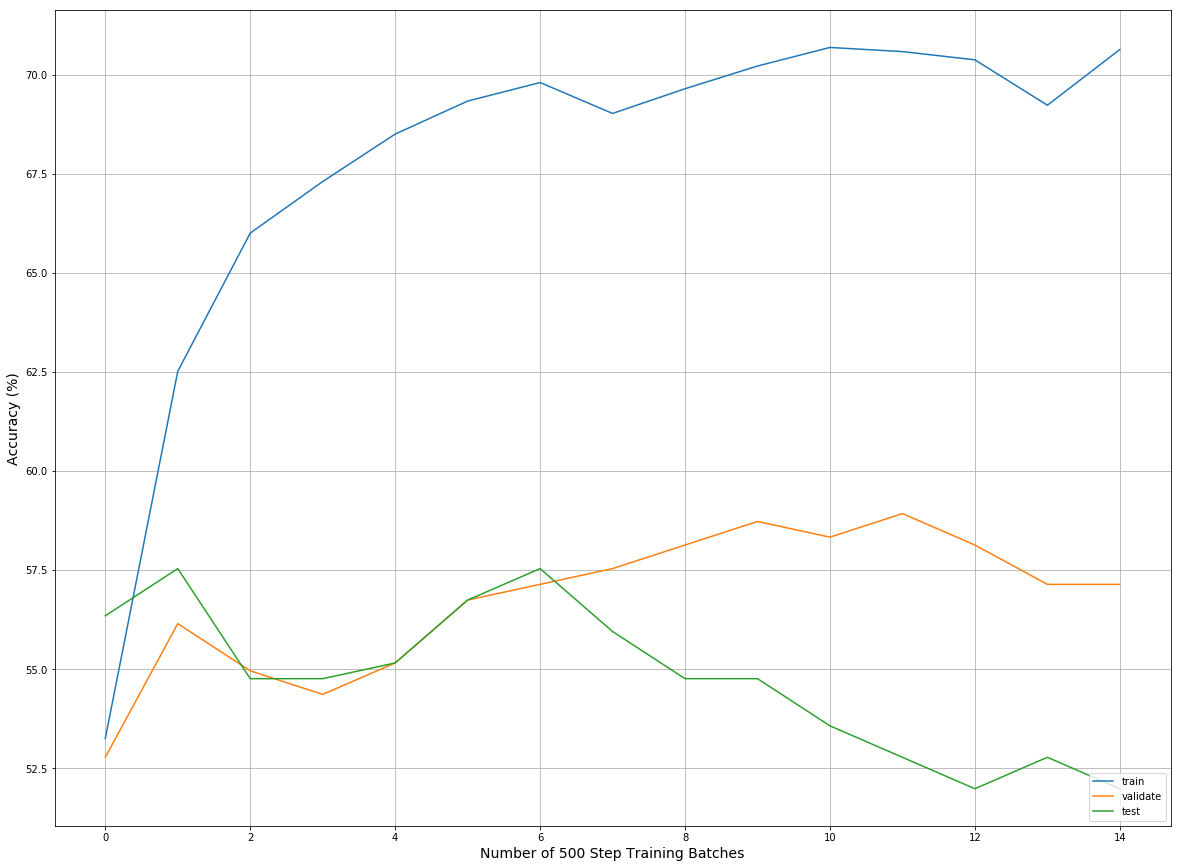

In [38]:
fig = plt.figure()
fig.set_size_inches(20, 15, forward=True)
plt.plot(step_train_accuracy, label="train")
plt.plot(step_valid_accuracy, label="validate")
plt.plot(step_test_accuracy, label="test")
plt.grid(True)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xlabel("Number of 500 Step Training Batches", fontsize=14)
plt.legend(loc=4)

# Trading Simulation

The model's performance will now be compared to two benchmark trading strategies, over the 252 day test set (10/01/2015 - 09/29/2016):

1. Buy and hold - the index is purchased at the opening price on the first day of the test period and then sold at the closing price of the last day of the test period.

2. Buy only - since always buying has a slight (52-54%) accuracy advantage over selling, the index is bought each day at the opening price and then sold at the closing price. This strategy is repeated each day, in contrast to the 'buy and hold' approach, which involves a single buy and a single sell event.

The model itself is evaluated as follows: if the model predicts the price will close higher, then the index is bought at the open and sold at the close. If the model predicts the price will close lower, then the index is sold at the open and bought at the close.

In [39]:
# Identify and format data needed for trading profit calculations

validated_data_limited = pd.DataFrame(validated_data.loc[:, "Date":"SP_Close"])
validated_data_limited = validated_data_limited[0:252]

# Read in the NN Model predictions:
ML_trading_data = pd.read_csv("./data/eval-NN.csv", header=None)

# If column 1 > column 0, then the label (prediction) is '1' (i.e. S&P500 is predicted to increase that day)
ML_trading_data["Predicted_Up"] = ML_trading_data[0] + ML_trading_data[1]

ML_trading_data.loc[ML_trading_data[1] > 0.5, "Predicted_Up"] = 1
ML_trading_data.loc[ML_trading_data[1] <= 0.5, "Predicted_Up"] = 0

# Append the model predictions to the market data:

validated_data_limited["Predicted_Up"] = ML_trading_data["Predicted_Up"]

# Reverse the dataframe order, so dates go from oldest to newest:
validated_data_limited = validated_data_limited.iloc[::-1]

# Buy and hold benchmark calculation:

validated_data_limited["Cum_Buy_Hold_Profit"] = validated_data_limited["SP_Close"] - (
    validated_data_limited["SP_Open"][251]
)

# Buy only benchmark calculation:

validated_data_limited["Buy_Only_Profit"] = (
    validated_data_limited["SP_Close"] - validated_data_limited["SP_Open"]
)
validated_data_limited["Cum_Buy_Only_Profit"] = np.cumsum(validated_data_limited["Buy_Only_Profit"])

# NN model results:
# Model profit is equal to the buy only profit, adjusted with a negative sign if the event is a sell instead:

validated_data_limited["Model_Profit"] = validated_data_limited["Buy_Only_Profit"] * (
    2 * validated_data_limited["Predicted_Up"] - 1
)

validated_data_limited["Cum_Model_Profit"] = np.cumsum(validated_data_limited["Model_Profit"])

# Output the final cumulative profit for the ML strategy and the benchmarks:

print(
    f"Cumulative Buy and Hold Strategy Profit ($): {validated_data_limited['Cum_Buy_Hold_Profit'][0]}"
)
print(
    f"Cumulative Buy Only Strategy Profit ($): {validated_data_limited['Cum_Buy_Only_Profit'][0]}"
)
print(
    f"Cumulative Machine Learning Strategy Profit ($): {validated_data_limited['Cum_Model_Profit'][0]}"
)

Cumulative Buy and Hold Strategy Profit ($): 12.72021500000028
Cumulative Buy Only Strategy Profit ($): -15.74315900000147
Cumulative Machine Learning Strategy Profit ($): 535.6782289999937


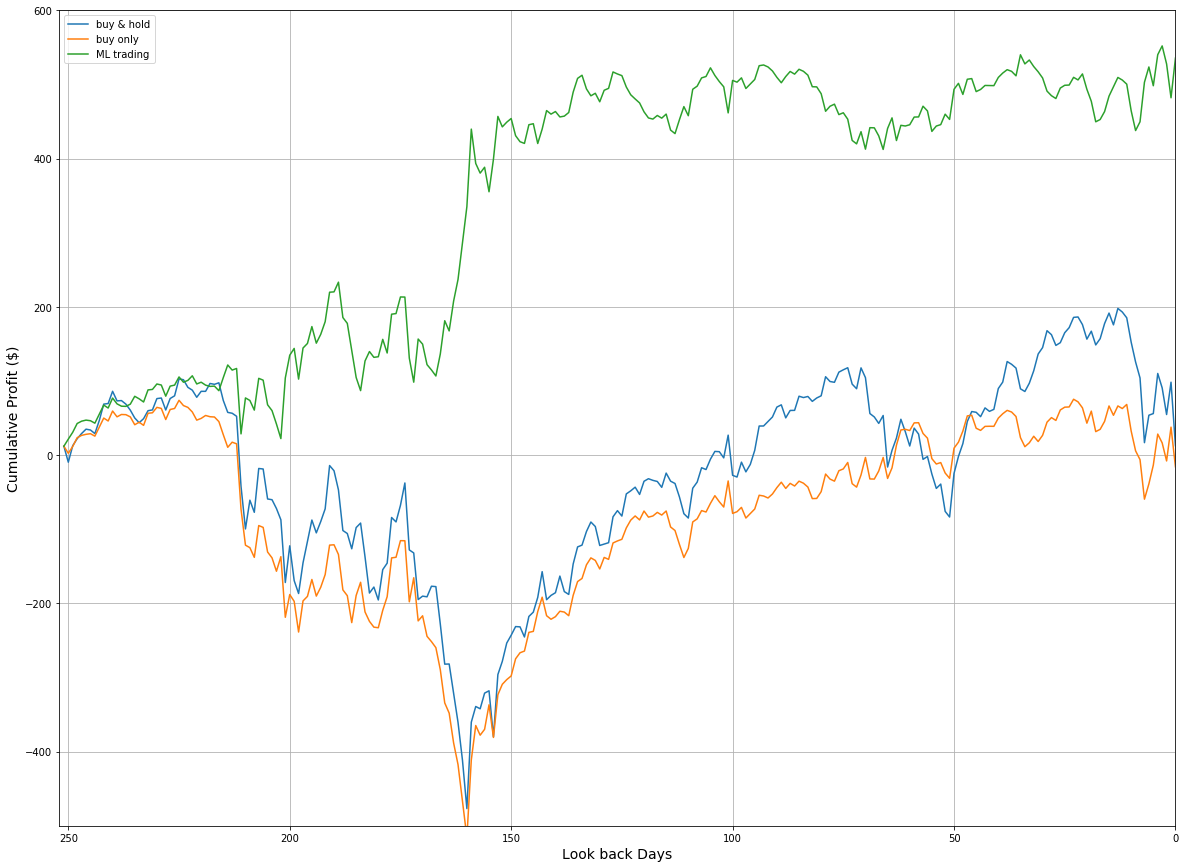

In [40]:
# Plot the cumulative performance of the ML trading strategy compared to the benchmarks:

trading_data = validated_data_limited

fig = plt.figure()
fig.set_size_inches(20, 15, forward=True)
plt.axis([252, 0, -500, 600])
plt.grid(True)

plt.plot(trading_data["Cum_Buy_Hold_Profit"], label="buy & hold")
plt.plot(trading_data["Cum_Buy_Only_Profit"], label="buy only")
plt.plot(trading_data["Cum_Model_Profit"], label="ML trading")

plt.ylabel("Cumulative Profit ($)", fontsize=14)
plt.xlabel("Look back Days", fontsize=14)
plt.legend(loc=2)

In [41]:
print("Buy Only Daily Profit Summary Statistics:")
display(validated_data_limited["Buy_Only_Profit"].describe())
print("\n")
print("ML Trading Daily Profit Summary Statistics:")
display(validated_data_limited["Model_Profit"].describe())

Buy Only Daily Profit Summary Statistics:


count    252.000000
mean      -0.062473
std       22.525687
min      -88.219970
25%       -8.107361
50%        0.914917
75%       11.277405
max      104.579834
Name: Buy_Only_Profit, dtype: float64



ML Trading Daily Profit Summary Statistics:


count    252.000000
mean       2.125707
std       22.424850
min      -88.219970
25%       -8.167420
50%        0.714966
75%       11.880066
max      104.579834
Name: Model_Profit, dtype: float64